In [13]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations_final/'


In [2]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    return pd.concat(ret_list)

In [3]:
sns.set(palette='muted', context='talk', style='ticks')

In [4]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': 'int32', 'trial_num': 'int32', 'trialID': 'int32',
    },
    index_col=False,
)

samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
#     'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
#     .query('subject_id not in [2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

samples_df = samples_df[[
    'subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation', 'eye_hit', 'grasp',
    'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration', 'grasp_end_bool', 'grasp_duration', 
    'is_outlier_fixation', 'pickup_location', 'drop_location'
]]

valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (31,69,70) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(10153442, 71)
(0, 71)


In [6]:
samples_df = samples_df.loc[:, ~samples_df.columns.duplicated()]

In [5]:
samples_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9068825 entries, 8905 to 10153441
Data columns (total 15 columns):
 #   Column               Dtype         
---  ------               -----         
 0   subject_id           float64       
 1   trial_num            float64       
 2   trial_type           object        
 3   timestamp_dt         datetime64[ns]
 4   is_fixation          bool          
 5   eye_hit              object        
 6   grasp                object        
 7   grasp_onset_bool     bool          
 8   eye_shelf_hit        object        
 9   fix_duration         float64       
 10  grasp_end_bool       bool          
 11  grasp_duration       float64       
 12  is_outlier_fixation  bool          
 13  pickup_location      object        
 14  drop_location        object        
dtypes: bool(4), datetime64[ns](1), float64(4), object(6)
memory usage: 864.9+ MB


In [14]:
samples_df.subject_id.nunique()

54

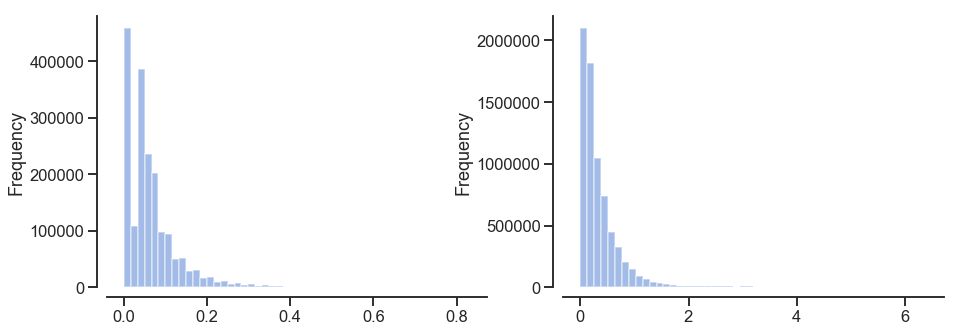

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
samples_df[samples_df.is_fixation == 0].fix_duration.plot.hist(bins=50, alpha=0.5, ax=ax[0])
samples_df[samples_df.is_fixation == 1].fix_duration.plot.hist(bins=50, alpha=0.5, ax=ax[1]);
sns.despine(offset=10)

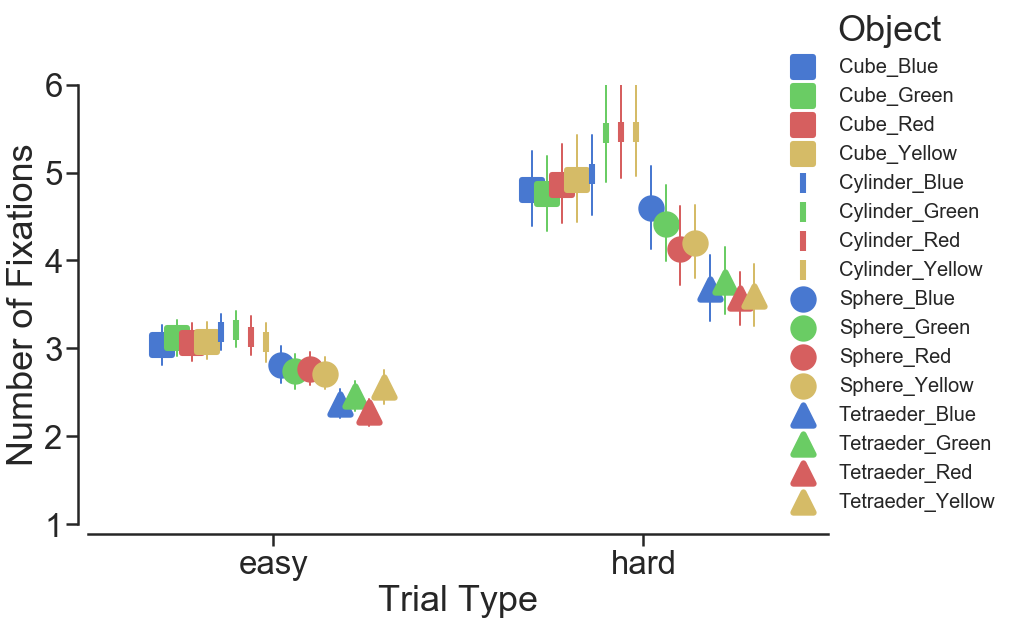

In [8]:
objs = [
    'Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow', 
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow'
]
markers = ['s','s','s','s', '|','|','|','|', 'o','o','o','o', '^','^','^','^']

colors = ['b', 'g', 'r', 'y']

tmpdf = (samples_df
 .drop_duplicates(subset=['fix_duration'], keep='first')
 .query('is_fixation == 1 and fix_duration !=0 and eye_hit != "Other"')
 .groupby(['subject_id','trial_type','trial_num','eye_hit'], as_index=False)
 .timestamp_dt
 .count()
 .rename(columns = {'timestamp_dt':'NumFixation'})
)

sns.set(context = "poster", style="ticks", palette="muted", font_scale=1.5, rc={'figure.figsize':(12,9),})
g = sns.catplot(
        x='trial_type', y='NumFixation', data=tmpdf, hue ='eye_hit', 
        hue_order=objs, markers=markers, palette=colors,
        kind='point',scale = 1.5,
        errwidth=2., capsize=0.,
        ci=95,  dodge=0.6, join=False,
        height=8, aspect = 1.5, legend_out=False, legend=False        
    )
sns.despine(offset=10)
g.set(ylim = (1,6), ylabel='Number of Fixations', xlabel='Trial Type')
plt.legend(title='Object',loc='upper right', frameon=False, bbox_to_anchor=(1.25, 1.2), fontsize=20, ncol=1)
plt.savefig(PLOT_PATH+'/fixationspertrial_perobj.png', transparent=True, bbox_inches='tight', quality=90)

In [9]:
# in seconds
bin_size = 0.25
offset_start = -3
offset_stop = 3

grp_cols = ['subject_id', 'trial_num']
grasp_epochs_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id == @subjects')
        .groupby(grp_cols),
        partial(get_epoch_grasp_on, offset_start=offset_start, offset_stop=offset_stop)
    )
)
grasp_epochs_df.head()

timestamp_dt  \
subject_id trial_num trial_type grasp_num                                 
2006.0     2.0       hard       0         1970-01-01 00:01:13.080635071   
                                0         1970-01-01 00:01:13.092376709   
                                0         1970-01-01 00:01:13.103027344   
                                0         1970-01-01 00:01:13.113960266   
                                0         1970-01-01 00:01:13.125236511   

                                           is_fixation eye_hit eye_shelf_hit  \
subject_id trial_num trial_type grasp_num                                      
2006.0     2.0       hard       0                 True   Other           5_1   
                                0                False   Other           4_1   
                                0                False   Other           4_2   
                                0                False   Other           4_2   
                                0                False   Other           4_2   

                                          target_object_fix target_shelf_fix  \
subject_id trial_num trial_type grasp_num                                      
2006.0     2.0       hard       0                       NaN            False   
                                0                       NaN            False   
                                0                       NaN            False   
                                0                       NaN            False   
                                0                       NaN            False   

                                          non_target_object_fix  \
subject_id trial_num trial_type grasp_num                         
2006.0     2.0       hard       0                           NaN   
                                0                           NaN   
                                0                           NaN   
                                0                           NaN   
                                0                           NaN   

                                          non_target_shelf_fix  \
subject_id trial_num trial_type grasp_num                        
2006.0     2.0       hard       0                         True   
                                0                         True   
                                0                         True   
                                0                         True   
                                0                         True   

                                              grasp_object  \
subject_id trial_num trial_type grasp_num                    
2006.0     2.0       hard       0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   

                                                             grasp_time  \
subject_id trial_num trial_type grasp_num                                 
2006.0     2.0       hard       0         1970-01-01 00:01:16.079879761   
                                0         1970-01-01 00:01:16.079879761   
                                0         1970-01-01 00:01:16.079879761   
                                0         1970-01-01 00:01:16.079879761   
                                0         1970-01-01 00:01:16.079879761   

                                                              drop_time  \
subject_id trial_num trial_type grasp_num                                 
2006.0     2.0       hard       0         1970-01-01 00:01:17.879341125   
                                0         1970-01-01 00:01:17.879341125   
                                0         1970-01-01 00:01:17.879341125   
                                0         1970-01-01 00:01:17.879341125   
                                0         1970-01-01 00:01:17.87934

In [10]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
avg_fixations_df = (
    pandas_mp_apply(
        grasp_epochs_df.query('is_fixation == 1').groupby(grp_cols),
        get_avg_fixations_time_binned,
    )
)
avg_fixations_df.head()

target_object_fix_count  \
subject_id trial_num trial_type time_bin                            
2006.0     2.0       hard       -2.75                          13   
                                -2.50                          28   
                                -2.25                          22   
                                -2.00                          21   
                                -1.75                          22   

                                          total_object_fix_count  \
subject_id trial_num trial_type time_bin                           
2006.0     2.0       hard       -2.75                        140   
                                -2.50                        123   
                                -2.25                        117   
                                -2.00                        132   
                                -1.75                        139   

                                          target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                           
2006.0     2.0       hard       -2.75                          0   
                                -2.50                          0   
                                -2.25                          3   
                                -2.00                          8   
                                -1.75                          9   

                                          total_shelf_fix_count  \
subject_id trial_num trial_type time_bin                          
2006.0     2.0       hard       -2.75                       140   
                                -2.50                       123   
                                -2.25                       117   
                                -2.00                       132   
                                -1.75                       139   

                                          non_target_object_fix_count  \
subject_id trial_num trial_type time_bin                                
2006.0     2.0       hard       -2.75                              68   
                                -2.50                              57   
                                -2.25                              43   
                                -2.00                              37   
                                -1.75                              42   

                                          non_target_shelf_fix_count  \
subject_id trial_num trial_type time_bin                               
2006.0     2.0       hard       -2.75                             42   
                                -2.50                             19   
                                -2.25                             23   
                                -2.00                             57   
                                -1.75                             52   

                                          proximity_pick  proximity_drop  \
subject_id trial_num trial_type time_bin                                   
2006.0     2.0       hard       -2.75           2.132231        2.570248   
                                -2.50           1.476636        2.140187   
                                -2.25           1.025862        2.370690   
                                -2.00           1.545455        2.500000   
                                -1.75           1.654676        2.431655   

                                          target_object_fix_prop  \
subject_id trial_num trial_type time_bin                           
2006.0     2.0       hard       -2.75                   0.092857   
                                -2.50                   0.227642   
                                -2.25                   0.188034   
                                -2.00                   0.159091   
                                -1.75                   0.158273   

                                          target_shelf_fix_prop  \
subject_id trial_num trial_type time_bin

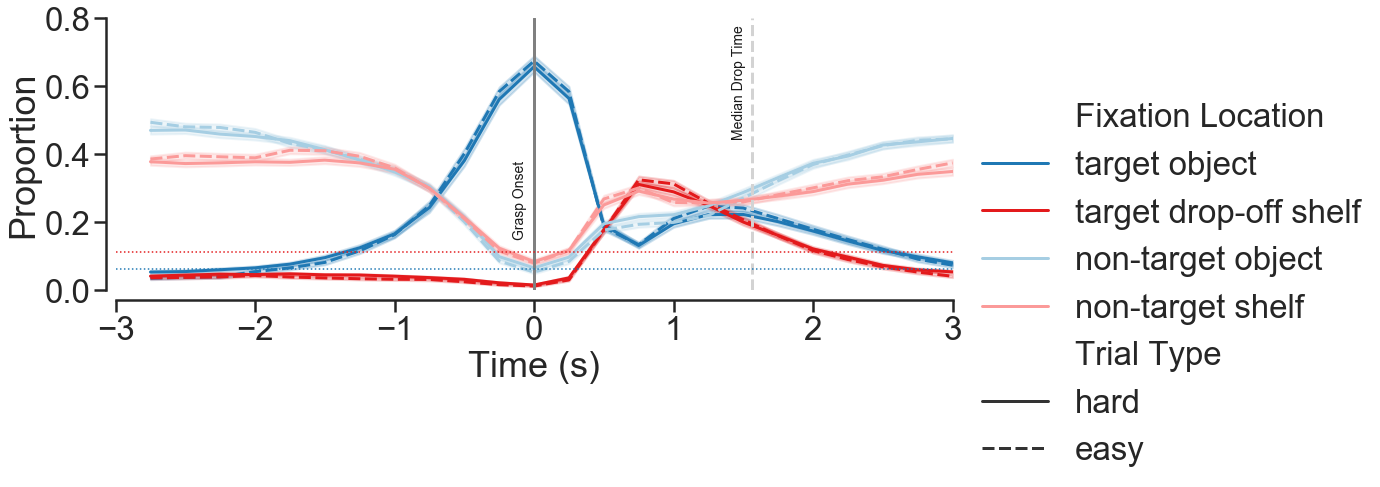

In [11]:
tmpdf = pd.melt(
    avg_fixations_df.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'trial_type', 'time_bin'], 
    value_vars= ['target_object_fix_prop', 'target_shelf_fix_prop',
                 'non_target_object_fix_prop', 'non_target_shelf_fix_prop'],
    var_name='Fixation Location', 
    value_name='Proportion'
)

tmpdf['Fixation Location'] = tmpdf['Fixation Location'].map({'target_object_fix_prop':'target object', 
                                               'target_shelf_fix_prop':'target drop-off shelf',
                                               'non_target_object_fix_prop': 'non-target object', 
                                               'non_target_shelf_fix_prop':'non-target shelf'})

tmpdf.rename(columns={'trial_type':'Trial Type'}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
scpt = sns.color_palette('Paired')
sns.lineplot(
    data=tmpdf,
    x='time_bin', y='Proportion', 
#      lw=4,
    hue='Fixation Location',
     style='Trial Type',
     legend='auto',
    palette=[scpt[1], scpt[5], scpt[0], scpt[4]],
    ax=ax,
#      label='target object',
     ci=95,
)
sns.despine(offset=10)

ax.axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax.text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() 
    / np.timedelta64(1, 's') - 0.15,
    0.75, 'Median Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax.axvline(0, color='grey', ls='-')
ax.text(-0.15, 0.35, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)

ax.axhline(1/9., color=scpt[5], ls=':', lw=1.5) # chance level for 1 of 9 empty sheves
ax.axhline(1/16., color=scpt[1], ls=':', lw=1.5) # chance level for 1 of 16 objects
ax.set_xlabel('Time (s)')
ax.set_ylim(0,0.8)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
ax.set_xlim(-3,3)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8), ncol=1)

plt.savefig(
    f'{PLOT_PATH}time_course_proportion.png', 
    transparent=True, 
    format='png',
    bbox_inches='tight', 
    quality=90
)
del tmpdf

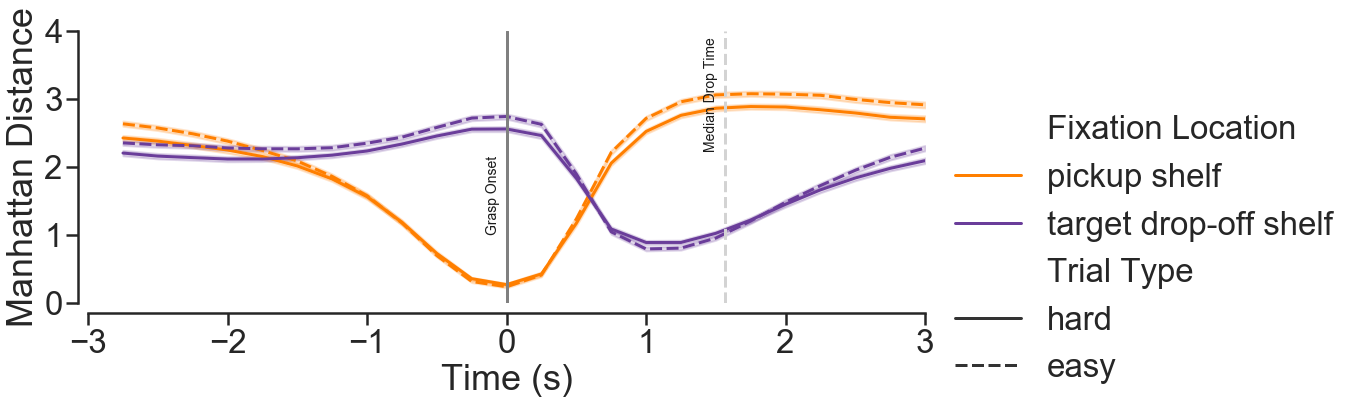

In [12]:
tmpdf = pd.melt(
    avg_fixations_df.reset_index(), 
    id_vars=['subject_id', 'trial_num', 'trial_type', 'time_bin'], 
    value_vars= ['proximity_pick', 'proximity_drop',],
    var_name='Fixation Location', 
    value_name='distance'
)

tmpdf['Fixation Location'] = tmpdf['Fixation Location'].map({'proximity_pick':'pickup shelf', 
                                               'proximity_drop':'target drop-off shelf',})

tmpdf.rename(columns={'trial_type':'Trial Type'}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
scpt = sns.color_palette('Paired')
sns.lineplot(
    data=tmpdf,
    x='time_bin', y='distance', 
#      lw=4,
    hue='Fixation Location',
     style='Trial Type',
     legend='auto',
    palette=[scpt[7], scpt[9],],
    ax=ax,
#      label='target object',
     ci=95,
)
sns.despine(offset=10)

ax.axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() / np.timedelta64(1, 's'),
    color='lightgrey', ls='--',
)
ax.text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() 
    / np.timedelta64(1, 's') - 0.15,
    3.75, 'Median Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)

ax.text(-0.15, 2, 'Grasp Onset', {'color': 'k', 'fontsize': 14}, rotation=90,)
ax.axvline(0, color='grey', ls='-')
ax.set_ylabel('Manhattan Distance')
ax.set_xlabel('Time (s)')
ax.set_ylim(0,4)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_xlim(-3,3)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.8))

plt.savefig(
    f'{PLOT_PATH}time_course_fix_distance.png', 
    transparent=True, 
    format='png',
    bbox_inches='tight', 
    quality=90
)
del tmpdf

In [15]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
avg_fixations_during_grasp_df = (
    pandas_mp_apply(
        grasp_epochs_df.groupby(grp_cols),
        get_avg_fixations_time_total,
    )
)
avg_fixations_during_grasp_df.head()

target_object_fix_count  \
subject_id trial_num trial_type                            
2006.0     2.0       hard                            766   
           3.0       hard                            528   
           4.0       hard                           1095   
           5.0       easy                            916   
           6.0       easy                            732   

                                 total_object_fix_count  \
subject_id trial_num trial_type                           
2006.0     2.0       hard                          1963   
           3.0       hard                          1780   
           4.0       hard                          3510   
           5.0       easy                          2945   
           6.0       easy                          1957   

                                 target_shelf_fix_count  \
subject_id trial_num trial_type                           
2006.0     2.0       hard                           334   
           3.0       hard                           381   
           4.0       hard                           458   
           5.0       easy                           533   
           6.0       easy                           342   

                                 total_shelf_fix_count  \
subject_id trial_num trial_type                          
2006.0     2.0       hard                         1963   
           3.0       hard                         1780   
           4.0       hard                         3510   
           5.0       easy                         2945   
           6.0       easy                         1957   

                                 non_target_object_fix_count  \
subject_id trial_num trial_type                                
2006.0     2.0       hard                                415   
           3.0       hard                                346   
           4.0       hard                               1044   
           5.0       easy                                770   
           6.0       easy                                396   

                                 non_target_shelf_fix_count  proximity_pick  \
subject_id trial_num trial_type                                               
2006.0     2.0       hard                               358        2.107425   
           3.0       hard                               424        2.172174   
           4.0       hard                               801        1.858122   
           5.0       easy                               621        1.897085   
           6.0       easy                               418        2.101641   

                                 proximity_drop  target_object_fix_prop  \
subject_id trial_num trial_type                                           
2006.0     2.0       hard              1.941022                0.390219   
           3.0       hard              1.594783                0.296629   
           4.0       hard              1.365401                0.311966   
           5.0       easy              1.355111                0.311036   
           6.0       easy              1.733192                0.374042   

                                 target_shelf_fix_prop  \
subject_id trial_num trial_type                          
2006.0     2.0       hard                     0.170148   
           3.0       hard                     0.214045   
           4.0       hard                     0.130484   
           5.0       easy                     0.180985   
           6.0       easy                     0.174757   

                                 non_target_object_fix_prop  \
subject_id trial_num trial_type                               
2006.0     2.0       hard                          0.211411   
           3.0       hard                          0.194382   
           4.0       hard                          0.297436   
           5.0       easy                          0.261460   
           6.0       easy                          0.202351   


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
tmpdf = (
    avg_fixations_during_grasp_df
    .query('trial_type=="easy"')
)
sns.distplot(
    tmpdf.non_target_object_same_feature_fix_prop, 
    color='b',
    norm_hist=True, 
    label='easy',
    ax=ax,
)
tmpdf = (
    avg_fixations_during_grasp_df
    .query('trial_type=="hard"')
)
sns.distplot(
    tmpdf.non_target_object_same_feature_fix_prop, 
    color='r',
    norm_hist=True, 
    label='hard',
    ax=ax,
)
ax.set_xlabel('Proportion of fixations on same feature objects')
ax.legend()
sns.despine(offset=10)

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


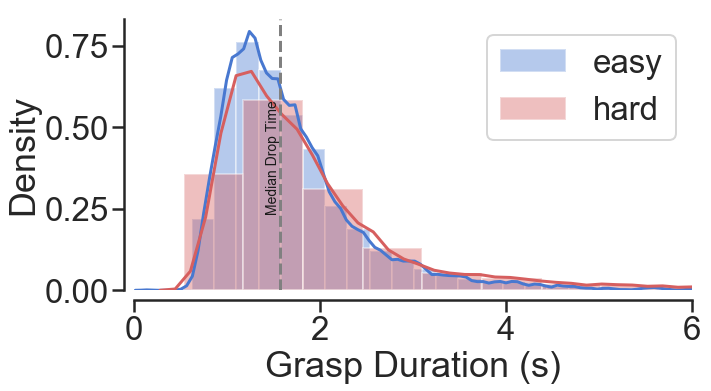

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
tmpdf = (
    grasp_epochs_df
    .query('trial_type=="easy"')
)
ax = sns.distplot(
        (tmpdf.drop_time - tmpdf.grasp_time).values / np.timedelta64(1, 's'),
        color='b',
        norm_hist=True, 
        label='easy',
        ax=ax,
)

tmpdf = (
    grasp_epochs_df
    .query('trial_type=="hard"')
)
ax = sns.distplot(
        (tmpdf.drop_time - tmpdf.grasp_time).values / np.timedelta64(1, 's'),
        color='r',
        norm_hist=True,
        label='hard',
        ax=ax,
)
ax.axvline(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() / np.timedelta64(1, 's'),
    color='grey', ls='--',
)
ax.text(
    (grasp_epochs_df.drop_time - grasp_epochs_df.grasp_time).median() 
    / np.timedelta64(1, 's') - 0.15,
    0.55, 'Median Drop Time', {'color': 'k', 'fontsize': 14}, rotation=90,
)
ax.set_xlabel('Grasp Duration (s)');
ax.set_xlim(0,6)
ax.legend()
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}grasp_duration', transparent=True, bbox_inches='tight', quality=90)

In [17]:
grp_cols = ['subject_id', 'trial_num']
plan_epochs_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id in @subjects')
        .groupby(grp_cols),
        partial(get_epoch_grasp_between,
                offset_start=0, offset_stop=0
               )
    )
)
plan_epochs_df.head()

hit_counts
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object eye_hit                    
2006.0     2.0       hard       0         Tetraeder_Green      Cylinder_Green    Cylinder_Green          151
                                                                                 Cylinder_Red             24
                                                                                 Other                   120
                                                                                 Tetraeder_Green         114
                                1         Cylinder_Green       Sphere_Green      Cylinder_Blue             3

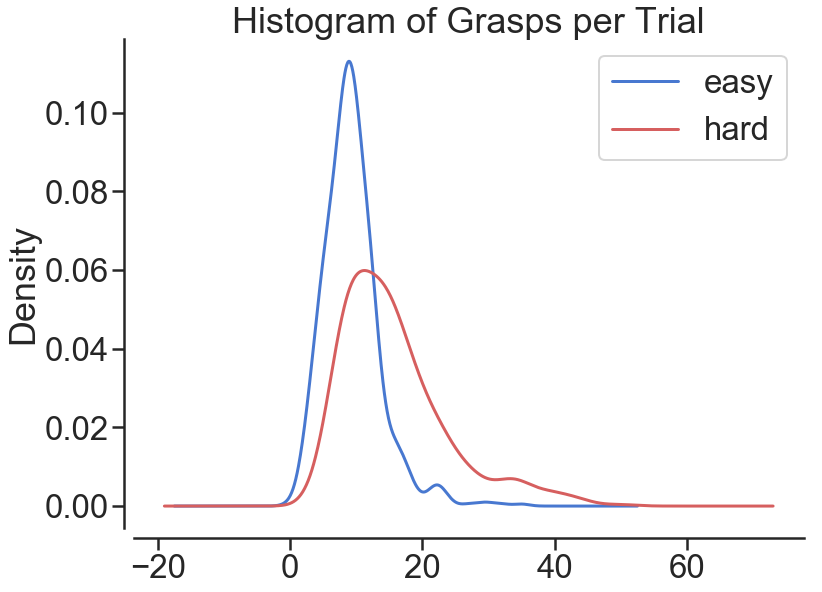

In [63]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1.5,)

ax = (
    plan_epochs_df
    .reset_index()
    .query('trial_type == "easy"')
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .grasp_num.max()
    .pipe(lambda s: s[s <= 50])
    .plot(kind='kde', label='easy', color='b')
)
ax = (
    plan_epochs_df
    .reset_index()
    .query('trial_type == "hard"')
    .groupby(['subject_id', 'trial_num', 'trial_type'])
    .grasp_num.max()
    .pipe(lambda s: s[s <= 50])
    .plot(kind='kde', ax=ax, label='hard', color='r')
)
ax.legend()
# ax.set_xlim(0,50)
plt.title('Histogram of Grasps per Trial');
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}grasps_per_trial', transparent=True, bbox_inches='tight', quality=90)


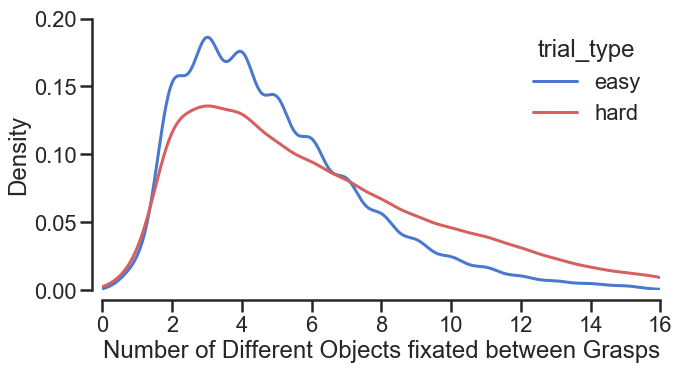

In [38]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1.,)
grp_cols = ['subject_id', 'trial_num', 'trial_type', 'grasp_num']
fig, ax = plt.subplots(figsize=(10, 5))
(
    plan_epochs_df
    .query('trial_type == "easy"')
    .reset_index('eye_hit')
    .query('eye_hit != "Other"')
    .groupby(grp_cols)
    .size()
    .plot(kind='kde', label='easy', color='b',)
)
(
    plan_epochs_df
    .query('trial_type == "hard"')
    .reset_index('eye_hit')
    .query('eye_hit != "Other"')
    .groupby(grp_cols)
    .size()
    .plot(kind='kde', color='r', label='hard')
)
plt.xlabel('Number of Different Objects fixated between Grasps')
# plt.title('Histogram of Fixated Object Count between Grasps');
sns.despine(offset=10)
ax.set_xlim(0,16)
ax.set_xticks(np.arange(0,18, 2))
ax.set_ylim(0,0.2)
ax.legend(frameon=False, title='trial_type')
plt.savefig(f'{PLOT_PATH}fixations_between_grasps', transparent=True, bbox_inches='tight', quality=90)


Most epochs between two grasps have fixations on 2-4 different objects, which means most often the subject is thinking about 2-4 different objects (or next moves) between two grasps. Very rarely do the subjects look around at more than 10 objects between grasps.  


The next thing to explore here is to discover the source of the mixture of poisson and this distribution across different cross sections.

In [57]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
lookahead_grasps_df = (
    pandas_mp_apply(
        (
            plan_epochs_df
#             .reset_index()
#             .loc[pd.IndexSlice[2007, :, :, :, :, :]]
            .groupby(grp_cols)
        ),
        get_lookahead_grasps
    )
)
lookahead_grasps_df.head()

eye_hit  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                   
2006.0     2.0       hard       8         Cube_Yellow          Cylinder_Blue           Cube_Blue   
                                                               Cylinder_Blue            Cube_Red   
                                                               Cylinder_Blue         Cube_Yellow   
                                                               Cylinder_Blue       Cylinder_Blue   
                                                               Cylinder_Blue      Cylinder_Green   

                                                                                  hit_counts  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object               
2006.0     2.0       hard       8         Cube_Yellow          Cylinder_Blue               3   
                                                               Cylinder_Blue               1   
                                                               Cylinder_Blue             211   
                                                               Cylinder_Blue              95   
                                                               Cylinder_Blue              46   

                                                                                  lookahead_grasp_num  \
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                        
2006.0     2.0       hard       8         Cube_Yellow          Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   
                                                               Cylinder_Blue                      NaN   

                                                                                  lookahead_distance  
subject_id trial_num trial_type grasp_num current_grasp_object next_grasp_object                      
2006.0     2.0       hard       8         Cube_Yellow          Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN  
                                                               Cylinder_Blue                     NaN

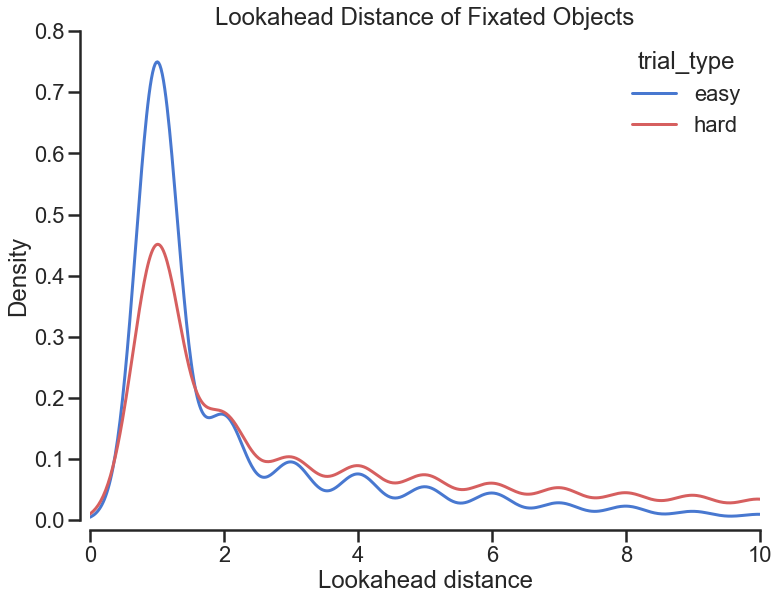

In [31]:
ax = (
    lookahead_grasps_df
    .query('trial_type == "easy"')
    .lookahead_distance
    .pipe(lambda s: s[s <= 10])
    .plot(kind='kde', label='easy', color='b')
)
(
    lookahead_grasps_df
    .query('trial_type == "hard"')
    .lookahead_distance
    .pipe(lambda s: s[s <= 10])
    .plot(kind='kde', color='r', ax=ax, label='hard')
)
# ax.set_xlim(0,20)
ax.set_xticks(np.arange(0, 11, 2));
ax.set_xlabel('Lookahead distance')
ax.set_xlim(0, 10)
ax.set_ylim(0, 0.8)
plt.title('Lookahead Distance of Fixated Objects')
ax.legend(frameon=False, title='trial_type')
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}lookahead_distance', transparent=True, bbox_inches='tight', quality=90)


C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


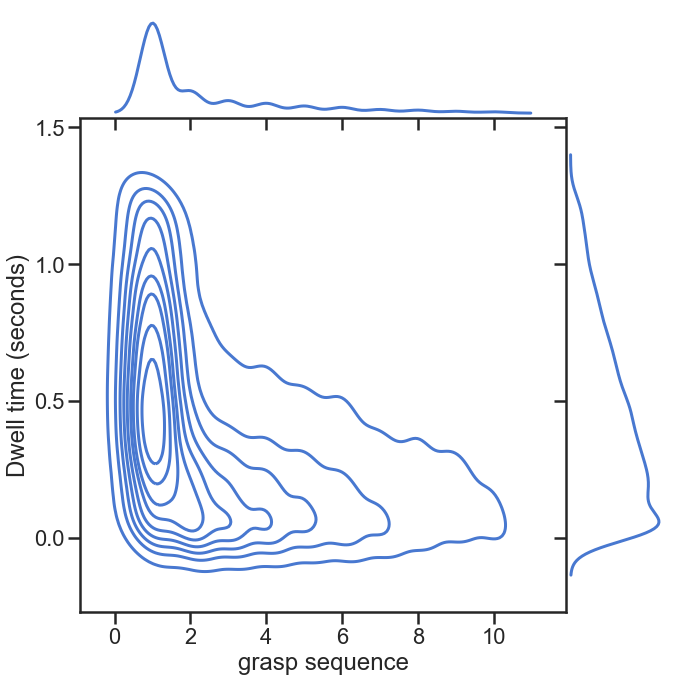

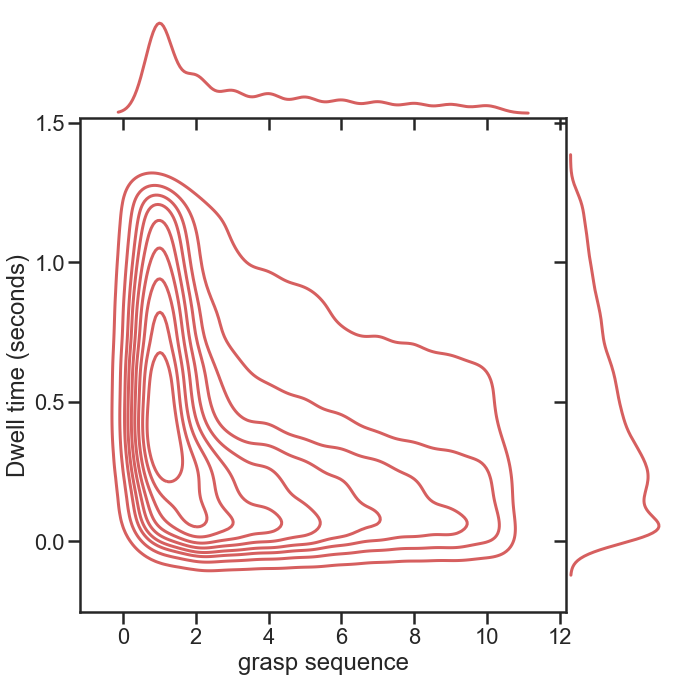

In [61]:
tmpdf = lookahead_grasps_df.query('lookahead_distance <=10 and hit_counts <= 100 and trial_type == "easy"')
tmpdf['fix_dur'] = tmpdf.hit_counts*0.0125
ax = sns.jointplot(
    x='lookahead_distance', y='fix_dur', 
    kind='kde',
    data=tmpdf, 
    space=0,
    height=10,
)
ax.ax_marg_y.set_yticks(np.arange(0, 1.6, 0.5))
ax.ax_joint.set_xlabel('grasp sequence')
ax.ax_joint.set_ylabel('Dwell time (seconds)')

plt.savefig(f'{PLOT_PATH}lookahead_distance_duration_easy', transparent=True, bbox_inches='tight', quality=90)

tmpdf = lookahead_grasps_df.query('lookahead_distance <=10 and hit_counts <= 100 and trial_type == "hard"')
tmpdf['fix_dur'] = tmpdf.hit_counts*0.0125
ax = sns.jointplot(
    x='lookahead_distance', y='fix_dur', 
    kind='kde',
    data=tmpdf, 
    space=0,
    height=10,
    color='r',
)
ax.ax_marg_y.set_yticks(np.arange(0, 1.6, 0.5))
ax.ax_joint.set_xlabel('grasp sequence')
ax.ax_joint.set_ylabel('Dwell time (seconds)')
plt.savefig(f'{PLOT_PATH}lookahead_distance_duration_hard', transparent=True, bbox_inches='tight', quality=90)
# sns.despine()

In [35]:
grp_cols = ['subject_id', 'trial_num', 'trial_type', 'grasp_num', 'current_grasp_object']
most_fixated_df = (
    plan_epochs_df
    .groupby(grp_cols)
    .apply(get_most_fixated)
    .to_frame('most_fixated')
    .groupby(['subject_id', 'trial_num', 'trial_type',])
    .apply(get_grasp_distance)
)
most_fixated_df.head()

most_fixated  \
subject_id trial_num trial_type grasp_num current_grasp_object                   
2006.0     2.0       hard       0         Tetraeder_Green       Cylinder_Green   
                                1         Cylinder_Green          Sphere_Green   
                                2         Sphere_Green             Sphere_Blue   
                                3         Sphere_Blue           Tetraeder_Blue   
                                4         Tetraeder_Blue          Cylinder_Red   

                                                                grasp_distance  
subject_id trial_num trial_type grasp_num current_grasp_object                  
2006.0     2.0       hard       0         Tetraeder_Green                  1.0  
                                1         Cylinder_Green                   1.0  
                                2         Sphere_Green                     1.0  
                                3         Sphere_Blue                      1.0  
                                4         Tetraeder_Blue                   1.0

In [25]:
most_fixated_df.shape

(15652, 2)

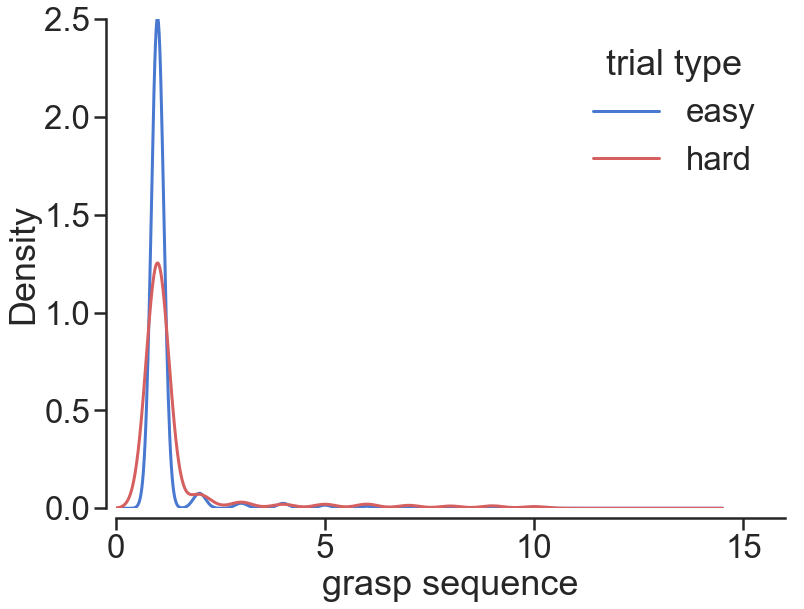

In [64]:
ax = (
    most_fixated_df
    .query('grasp_distance<=10 and trial_type == "easy"')
    .grasp_distance
    .plot(kind='kde', color='b', label='easy')
)
(
    most_fixated_df
    .query('grasp_distance<=10 and trial_type == "hard"')
    .grasp_distance
    .plot(kind='kde', color='r', label='hard', ax=ax)
)

# plt.title('Grasp Occurence of the most fixated Object');
sns.despine(offset=10)
ax.legend(frameon=False, title='trial type')
ax.set_xlim(0,16)
ax.set_ylim(0,2.5)
ax.set_xlabel('grasp sequence')
plt.savefig(f'{PLOT_PATH}lookahead_distance_most_fixated', transparent=True, bbox_inches='tight', quality=90)


In [27]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
monitoring_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id == @subjects')
        .groupby(grp_cols),
        partial(get_fixations_between_pickup_dropoff)
    )
)
monitoring_df.head()

eye_hit eye_shelf_hit  \
subject_id trial_num trial_type grasp_num                                  
2006       2         hard       0          Tetraeder_Green           3_2   
                                0          Tetraeder_Green           3_2   
                                0          Tetraeder_Green           3_2   
                                0          Tetraeder_Green           3_2   
                                0          Tetraeder_Green           3_2   

                                           target_object_fix  \
subject_id trial_num trial_type grasp_num                      
2006       2         hard       0                         94   
                                0                         94   
                                0                         94   
                                0                         94   
                                0                         94   

                                           target_shelf_fix  \
subject_id trial_num trial_type grasp_num                     
2006       2         hard       0                       118   
                                0                       118   
                                0                       118   
                                0                       118   
                                0                       118   

                                           non_target_object_fix  \
subject_id trial_num trial_type grasp_num                          
2006       2         hard       0                             58   
                                0                             58   
                                0                             58   
                                0                             58   
                                0                             58   

                                           non_target_shelf_fix  \
subject_id trial_num trial_type grasp_num                         
2006       2         hard       0                            34   
                                0                            34   
                                0                            34   
                                0                            34   
                                0                            34   

                                           non_target_object_same_color  \
subject_id trial_num trial_type grasp_num                                 
2006       2         hard       0                                    94   
                                0                                    94   
                                0                                    94   
                                0                                    94   
                                0                                    94   

                                           non_target_object_same_shape  \
subject_id trial_num trial_type grasp_num                                 
2006       2         hard       0                                    94   
                                0                                    94   
                                0                                    94   
                                0                                    94   
                                0                                    94   

                                              grasp_object  \
subject_id trial_num trial_type grasp_num                    
2006       2         hard       0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   
                                0          Tetraeder_Green   

                                                             grasp_time  \
subject_id trial_num trial_type grasp_num                                 
2006       2         hard       0         1

In [33]:
grp_cols = ['subject_id', 'trial_num', 'trial_type']
(
    monitoring_df
    .drop_duplicates(
        subset=['target_object_fix', 'target_shelf_fix', 
                'non_target_object_same_color', 'non_target_object_same_shape' ],
        keep='first')
    .groupby(grp_cols)
    .agg({'target_object_fix' : 'mean',
          'target_shelf_fix' : 'mean',
          'non_target_object_fix' : 'mean',
          'non_target_shelf_fix' : 'mean',
          'non_target_object_same_color' : 'mean',
          'non_target_object_same_shape' : 'mean',
         })
)

target_object_fix  target_shelf_fix  \
subject_id trial_num trial_type                                        
2006       2         hard               112.200000        129.400000   
           3         easy                37.222222         65.555556   
           4         hard                42.750000         54.200000   
           5         easy                45.266667         67.800000   
           6         easy                56.800000         72.900000   
...                                            ...               ...   
2065       19        hard                29.600000         70.866667   
           20        easy                25.777778         60.555556   
           21        easy                31.600000         63.400000   
           22        easy                24.000000         48.125000   
           23        hard                23.857143         40.285714   

                                 non_target_object_fix  non_target_shelf_fix  \
subject_id trial_num trial_type                                                
2006       2         hard                   165.000000            147.800000   
           3         easy                   128.666667            100.333333   
           4         hard                   108.150000             96.700000   
           5         easy                   115.600000             93.066667   
           6         easy                   101.200000             85.100000   
...                                                ...                   ...   
2065       19        hard                   139.800000             98.533333   
           20        easy                   149.111111            114.333333   
           21        easy                   109.800000             78.000000   
           22        easy                   123.000000             98.875000   
           23        hard                   114.857143             98.428571   

                                 non_target_object_same_color  \
subject_id trial_num trial_type                                 
2006       2         hard                          136.400000   
           3         easy                           45.888889   
           4         hard                           47.200000   
           5         easy                           50.000000   
           6         easy                           69.100000   
...                                                       ...   
2065       19        hard                           34.666667   
           20        easy                           30.777778   
           21        easy                           32.000000   
           22        easy                           38.625000   
           23        hard                           29.714286   

                                 non_target_object_same_shape  
subject_id trial_num trial_type                                
2006       2         hard                          121.000000  
           3         easy                           49.222222  
           4         hard                           51.200000  
           5         easy                           60.400000  
           6         easy                           58.600000  
...                                                       ...  
2065       19        hard                           45.400000  
           20        easy                           32.777778  
           21        easy                           34.800000  
           22        easy                           34.625000  
           23        hard                           28.428571  

[1144 rows x 6 columns]

In [ ]:
tmpdf = (
    monitoring_df
    .reset_index()
)
sns.displot(tmpdf.target_object_fix, hue=tmpdf.)